In [31]:

from scipy import stats

import matplotlib.pyplot as plt
import numpy as np

import numpy.random as rd

import pandas as pd 

from tqdm import tqdm
import math

In [32]:
_max  =1000

In [33]:
def h(x):
    global mu
    global sigma
    
    return (x-mu)**2/(2 * sigma)

def delta_h(x):
    global mu
    global sigma
    return  x/sigma - mu/sigma

In [34]:
L =100
def leap_flog_step1(r, eta,x):
    return r - 0.5*eta* delta_h(x)

def leap_flog_step2(r, x, eta):
    return x + eta * r

def Leapfrog(x,r, eta):
    for _ in range(L):
        r = leap_flog_step1(r, eta,x)
        x = leap_flog_step2(r, x, eta)
        r = leap_flog_step1(r, eta,x)
    return x,r

In [35]:
def momentum(r):
    return 0.5 * r**2

In [36]:
def hamiltonian(x,r):
    return h(x)+ momentum(r)

In [37]:
   
def BuildTree(x,r,u,v,j,eta):    
    if j == 0:
        x,r = Leapfrog(x,r,v*eta)
        c = [(x,r)] if u < np.exp(-hamiltonian(x,r)) else [(100,100)]
        s = 1 if -hamiltonian(x,r) > np.log(u)-_max else 0
        return x,r,x,r,c,s
    else:
        x_minus,r_minus, x_plus,r_plus,c,s = BuildTree(x,r,u,v,j-1,eta)    
        if v == -1:
            x_minus,r_minus, _,_,c_dash,s_dash = BuildTree(x_minus,r_minus,u,v,j-1,eta)
        elif v == 1:
            _,_, x_plus,r_plus,c_dash,s_dash = BuildTree(x_plus,r_plus,u,v,j-1,eta)
        else:
            print("Error")
        s = s *s_dash* (1 if (x_plus-x_minus)*r_minus >= 0 else 0) * (1 if (x_plus-x_minus)*r_plus >= 0 else 0)
        c.extend(c_dash)
        return x_minus,r_minus,x_plus,r_plus,c,s
                
                
                
                

In [48]:

# まあいろいろ初期値を設定
# 初期値が大きいと（正規分布)へんな感じでハマる可能性がある。



mu = 0
sigma = 1

In [49]:
M =4000
x_prior = 1
eta = 0.01
result = []
cnt = 0
for _ in range(0,M):
    p = rd.normal(loc=0,scale=1)
    u = rd.uniform(0.0, np.exp(-hamiltonian(x_prior,p)))
    x_minus,x_plus = x_prior,x_prior
    r_minus,r_plus = p,p
    j = 0
    c =[(x_prior,p)]
    s =1    
    while s == 1:
        v = rd.choice([-1,1])
        if v == -1:
            x_minus,r_minus, _,_, c_dash,s_dash = BuildTree(x_minus,r_minus,u,v,j,eta)
        elif v == 1:
            _,_, x_plus,r_plus,c_dash,s_dash = BuildTree(x_plus,r_plus,u,v,j,eta)
        else:
            print("error")
        if s_dash ==1:
            c.extend(c_dash)
        else:
            cnt +=1
        s = s_dash * (1 if (x_plus-x_minus)*r_minus >= 0 else 0) * (1 if (x_plus-x_minus)*r_plus >= 0 else 0)
        j = j +1
    choice_index = rd.choice(list(range(0, len(c))))
    x_prior = c[choice_index][0]
    result.append(x_prior)
    


In [50]:
# 採択率
1- cnt/len(result)

0.6355

(array([ 0.00678437,  0.02913286,  0.10695352,  0.29691575,  0.40187387,
         0.34640171,  0.15244868,  0.03990803,  0.01237149,  0.0039908 ]),
 array([-3.29133613, -2.57540433, -1.85947252, -1.14354072, -0.42760892,
         0.28832289,  1.00425469,  1.7201865 ,  2.4361183 ,  3.1520501 ,
         3.86798191]),
 <a list of 10 Patch objects>)

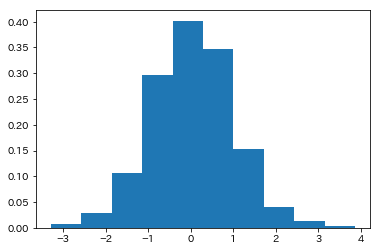

In [51]:
plt.hist(np.array(result[500:]),normed = True)